## Volcanic hazard exacerbated by future global warming–driven increase in heavy rainfall
### Jamie I. Farquharson, Falk Amelung
Rosenstiel School of Marine and Atmospheric Science, University of Miami, Miami, FL, USA

Corresponding author: jifarq89@googlemail.com

### Supplementary analyses

In [1]:
'''
filepath will point to current location of the Jupyter Notebook.
Creates directories if necessary.
'''
import os
from os import path
os.getcwd()
!pwd
def make_tree(directory):
    d = directory
    if not os.path.exists(d):
        os.mkdir(d)
    else:
        print("'{}' directory already exists".format(d))
make_tree("data")
make_tree("climate_mods")
make_tree("climate_figures")
work_dir = os.path.expanduser('work_dir')
filepath = os.getcwd()

/Users/jamiefarquharson/Documents/GitHub/rainfall-in-volcanic-regions
'data' directory already exists
'climate_mods' directory already exists
'climate_figures' directory already exists


### Import packages

In [2]:
'''
Import packages
'''

from netCDF4 import Dataset
import netCDF4

import numpy as np
import numpy.ma as ma
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.font_manager as font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams
from matplotlib import patheffects
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

buffer = [patheffects.withStroke(linewidth=1, foreground="w", alpha = 0.85)]
plt.rcParams["font.family"] = 'sans-serif'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Computer Modern Sans serif']
plt.rcParams["font.family"] = 'sans-serif'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino']
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import datetime as dt

import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scipy
from scipy.stats import gaussian_kde
from scipy import sparse
from scipy.stats import linregress

import os
import skimage
import skimage.transform
import glob
import string as STRING
import fnmatch
import time
import pylab
import hashlib
import pickle
import sys

from collections import Counter
from scipy.stats import chisquare
print("All packages imported")


All packages imported


In [17]:
filepath = '/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk'# 'path/to/directory'

In [18]:
if os.getcwd() != filepath:
    %cd $filepath

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk


In [3]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)


In [4]:
def call_plt_params():
    matplotlib.rcParams['text.usetex'] = True 
    matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'cm'
    plt.rcParams["font.family"] = 'sans-serif'

In [54]:
''' For plotting labels '''
labelArgs = {'xy': (0, 1),'xytext': (4,-4),
            'xycoords':'axes fraction',
            'textcoords':'offset points',}
labelKwargs = {
            'color':"k",
            'fontsize':12,
            'path_effects':buffer,
            'ha': 'left',
            'va': 'top',
            'zorder':np.inf}
altArgs =  {'xy': (1, 1),'xytext': (-4,-4),
            'xycoords':'axes fraction',
            'textcoords':'offset points',}

Load in perceptually uniform colourmaps from http://www.fabiocrameri.ch/colourmaps.php, http://doi.org/10.5281/zenodo.1243862

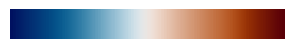

In [26]:
cm_data = np.loadtxt("climate_mods/ScientificColourMaps6/vik/vik.txt")
vik_map = LinearSegmentedColormap.from_list("vik", cm_data)
vik_map_r = LinearSegmentedColormap.from_list("vik", cm_data[::-1])
x = np.linspace(0, 100, 100)[None, :]
fig = plt.figure(1, mm2inch(90,10), dpi=100)
plt.imshow(x, aspect="auto",cmap=vik_map)
plt.axis("off")
plt.show()

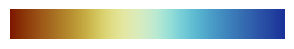

In [27]:

cm_data = np.loadtxt("climate_mods/ScientificColourMaps6/roma/roma.txt")
roma_map = LinearSegmentedColormap.from_list("roma", cm_data)
roma_map_r = LinearSegmentedColormap.from_list("roma", cm_data[::-1])
x = np.linspace(0, 10, 100)[None, :]
fig = plt.figure(1, mm2inch(90,10), dpi=100)
plt.imshow(x, aspect="auto",cmap=roma_map)
plt.axis("off")
plt.show()

In [28]:
'''Segment the "vik" colourmap'''

cmaplist = [vik_map_r(i) for i in range(vik_map_r.N)]
seg_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, vik_map_r.N)

# define the bins and normalise
bounds = np.linspace(-18, 18, 13)
norm = mpl.colors.BoundaryNorm(bounds, vik_map_r.N)


### Access volcano information and pre-process

In [36]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
# '''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")

'''
Update volcano names to avoid duplicates
'''
temp_list = list(volcano_list.Volcano_Name)
duplicate_names = list(set([x for x in temp_list if temp_list.count(x) > 1]))
duplicate_numbers = []
for j in volcano_list.index:
    if volcano_list.Volcano_Name[j] in duplicate_names:
        volcano_list.Volcano_Name[j] = volcano_list.Volcano_Name[j]+' ' + str(volcano_list.Volcano_Number[j])
        duplicate_numbers.append(volcano_list.Volcano_Number[j])
len(set(duplicate_numbers))
for j in eruption_list.index:
    if eruption_list.Volcano_Number[j] in duplicate_numbers:
        eruption_list.Volcano_Name[j] = eruption_list.Volcano_Name[j]+' ' + str(eruption_list.Volcano_Number[j])

volcanoes = list(set(eruption_list.Volcano_Name)) ## {
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.\n{} duplicate names:\n{}'.format(
    len(volcano_list),len(eruption_list),len(volcanoes), len(duplicate_names), duplicate_names))                           

--2022-07-05 21:26:01--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [         <=>        ]   2.01M   900KB/s    in 2.3s    

2022-07-05 21:26:04 (900 KB/s) - ‘Holocene_eruptions.csv’ saved [2109871]

--2022-07-05 21:26:04--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volca

In [37]:
'''
Extracts latitude and longitude data for each volcano in 'volcano_list' [formatted in the dataframe as 'POINT (x.xx x.xxx)'] (WKT format?).
Updates dataframe with extracted coordinates.
'''

lons = []
lats = []
for j,k in enumerate(volcano_list.GeoLocation):
    lons.append(float(k[7:-1].split()[0])) # Extracts longitude as string, converts to float
    lats.append(float(k[7:-1].split()[1])) # Extracts latitude as string, converts to float
volcano_list['lats'] = lats # Adds latitudes to original dataframe
volcano_list['lons'] = lons # Advods longitudes to original dataframe


lst = list(set(volcano_list.Primary_Volcano_Type))
filtered = fnmatch.filter(lst, 'Sub*') ## Filter out subglacial and submarine eruptions
volcano_list = volcano_list.loc[~volcano_list["Primary_Volcano_Type"].isin(filtered)]
print('Done\n\tand')

'''
Coordinates ready for plotting
'''
locations = volcano_list[['lats', 'lons']]
locations["name"] = volcano_list.Volcano_Name
locations["number"] = volcano_list.Volcano_Number
locationlist = locations.values.tolist
print('\t\tDone')

Done
	and
		Done


### Functions for reading and processing climate data

####  Model output data have been obtained through Earth System Grid Federation servers, in particular the node hosted by the Lawrence Livermore National Laboratory https://esgf-node.llnl.gov/search/cmip5/.

In [7]:
''' Models used '''
fileNameCodes = [['NorESM1-M',
  'CSIRO-Mk3-6-0',
  'MRI-CGCM3',
  'ACCESS1-3',
  'inmcm4',
  'MIROC5',
  'IPSL-CM5A-MR',
  'CanESM2',
  'CNRM-CM5']]

In [11]:
def list_of_models(parameter = "pr", modelName ="", rcp45=False):
    import glob as glob
    if rcp45==True:
        models = [mod for mod in glob.glob("climate_mods/rcp45/{}*".format(parameter))]
    else:
        models = [mod for mod in glob.glob("climate_mods/rcp85/{}*".format(parameter))]
    modelList = []
    for modelString in models:
        if modelName in modelString:
            modelList.append(modelString)
    return sorted(modelList)

In [12]:
def list_of_models_rcp26(parameter = "pr", modelName =""):
    import glob as glob
    models = [mod for mod in glob.glob("climate_mods/rcp26/{}*".format(parameter))]
    modelList = []
    for modelString in models:
        if modelName in modelString:
            modelList.append(modelString)
    return sorted(modelList)

In [13]:
def global_mean_temp(modelName, method = "max", verbose = False, rcp45=False):
    ''' "how" can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="ta", modelName=modelName, rcp45=rcp45))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        model_gmT = []
        for x in range(modelFile.variables["ta"].shape[0]):
            model_gmT.append(np.nanmean(modelFile.variables["ta"][x][0]))
        gmT_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'temp': model_gmT
    })
        gmT_df=gmT_df.set_index('ix')
        gmT_df.index = pd.to_datetime(gmT_df.index)
        gmT = gmT_df.resample("Y").agg(method)#, how=method)


        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return gmT, gmT_df
    except:
        print("Error reading {}".format(modelName))

def heavy_rainfall(i_volc, j_volc, modelName="", method = "max", verbose = False, rcp45 = False):
    ''' "how" method deprecated, use .agg(). Can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName, rcp45=rcp45))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        rx_volc = []
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]
        i = int(np.where(lat_vals==i_volc)[0])
        j = int(np.where(lon_vals==j_volc)[0])
        prcp = list(modelFile.variables["pr"][:,i,j])
        temp_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'rainfall': prcp
    })
        temp_df=temp_df.set_index('ix')
        temp_df.index = pd.to_datetime(temp_df.index)
        RX1 = temp_df.resample("Y").agg(method)#, how=method)
        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return temp_df, RX1
    except:
        print("Error reading {}".format(modelName))
        


In [20]:
def process_FMR(modelName="", resampled_gmT="", method = "max", verbose = False, rcp45 = False):
    ''' "how" method deprecated, use .agg(). Can be either "max" or "mean" '''
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName, rcp45=rcp45))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        rx1 = []
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]

        count = len(lat_vals)
        bar_size=40
        for j, lat in enumerate(lat_vals):
            for k, lon in enumerate(lon_vals):
                prcp = list(modelFile["pr"][:,j,k])
                temp_df = pd.DataFrame(
            {'ix':time,'date':time, ##
             'rainfall': prcp
            })
                temp_df=temp_df.set_index('ix')
                temp_df.index = pd.to_datetime(temp_df.index)
                RX1 = temp_df.resample("Y").agg(method)

                gmT = resampled_gmT #temp_df.resample("Y").agg("mean")
                timeframe = [int(x) for x in np.linspace(RX1.index[0].year, RX1.index[-1].year,len(RX1.rainfall))]
                RX1val = [x for x in RX1.rainfall.values]
                gmTval = [x for x in gmT.temp.values]
                gmTval_n = [x - gmTval[1] for x in gmTval[1::]]
                RX1val_n = [(x-RX1val[1])/RX1val[1]*100 for x in RX1val[1::]]

                mask = ~np.isnan(gmTval_n) & ~np.isnan(RX1val_n)
                m, c, r, p, s = linregress(
                    np.array(gmTval_n)[mask],
                    np.array(RX1val_n)[mask])
                rx1.append(m)
            bar_frac = int(bar_size*(j+1)/count)
            print("{} {} rainfall: |{}{}| {}/{}".format("Processing",modelName,
                                               u"█"*bar_frac, u"\u22c5"*(bar_size-bar_frac),
                                               j+1, count), 
            end='\r', file=sys.stdout, flush=True)
        modelFile.close()
        rx1_rs=np.reshape(rx1, (len(lat_vals),len(lon_vals)))
        print("\n{} data reshaped  ".format(modelName))
        return rx1, rx1_rs
   
    except:
#         print("Error reading {}".format(modelName))
        funcName = sys._getframe().f_code.co_name
        print("Error reading {} ({})".format(modelName, funcName))

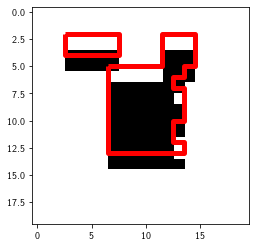

In [52]:
def get_all_boundary_edges(bool_img):
    """
    Get a list of all edges
    (where the value changes from 'True' to 'False') in the 2D image.
    Return the list as indices of the image.
    """
    ij_boundary = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            ij_boundary.append(np.array([[i, j+1],
                                         [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            ij_boundary.append(np.array([[i+1, j],
                                         [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            ij_boundary.append(np.array([[i, j],
                                         [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            ij_boundary.append(np.array([[i, j],
                                         [i, j+1]]))
    if not ij_boundary:
        return np.zeros((0, 2, 2))
    else:
        return np.array(ij_boundary)

def close_loop_boundary_edges(xy_boundary, clean=True):
    """
    Connect all edges defined by 'xy_boundary' to closed 
    boundary lines.
    If not all edges are part of one surface return a list of closed 
    boundaries is returned (one for every object).
    """

    boundary_loop_list = []
    while xy_boundary.size != 0:
        # Current loop
        xy_cl = [xy_boundary[0, 0], xy_boundary[0, 1]]  # Start with first edge
        xy_boundary = np.delete(xy_boundary, 0, axis=0)

        while xy_boundary.size != 0:
            # Get next boundary edge (edge with common node)
            ij = np.nonzero((xy_boundary == xy_cl[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                xy_cl.append(xy_cl[0])
                break

            xy_cl.append(xy_boundary[i, (j + 1) % 2, :])
            xy_boundary = np.delete(xy_boundary, i, axis=0)

        xy_cl = np.array(xy_cl)

        boundary_loop_list.append(xy_cl)

    return boundary_loop_list
def plot_world_outlines_(bool_img, ax=None, offs=[.5,.5],**kwargs):
    if ax is None:
        ax = plt.gca()
    else:
        ax = ax
    offs = offs
    ij_boundary = get_all_boundary_edges(bool_img=bool_img)
    xy_boundary = ij_boundary - offs
    xy_boundary = close_loop_boundary_edges(xy_boundary=xy_boundary)
    cl = LineCollection(xy_boundary,**kwargs)
#     cl.set_offsets( (0., 1))
    ax.add_collection(cl)


array = np.zeros((20, 20))
array[4:6, 3:8] = 1
array[4:7, 12:15] = 1
array[7:15, 7:14] = 1
array[12:14, 13:14] = 0
array[8:9, 13:14] = 0


plt.figure()
plt.imshow(array, cmap='binary')
plot_world_outlines_(array.T,ax=None,offs = (.5,2.), lw=5, color='r')

### The following cells allow the creation of numpy arrays from the original NetCDF model files.  
#### The user can skip to the cell `ls data/rcp45/*fmr.npy` to use pre-processed data


In [21]:

for mod in range(9):
    modelName = fileNameCodes[0][mod]
    method = "max"
    rcp45 = True
    
    global_mean_T, global_mean_T_df = global_mean_temp(
        modelName=modelName,
        method = method, verbose = False, rcp45 = rcp45)
    
#     heavy_rain, heavy_rain_reshaped, lat_vals, lon_vals = process_FMR(
#         modelName=modelName,
#         resampled_gmT=global_mean_T,
#         method = method, verbose = False, rcp45 = rcp45, return_lat_lon = False)
    heavy_rain, heavy_rain_reshaped = process_FMR(
        modelName=modelName,
        resampled_gmT=global_mean_T,
        method = method, verbose = False, rcp45 = rcp45)

    modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName, rcp45=rcp45))
    lat_vals = modelFile.variables["lat"][:]
    lon_vals = modelFile.variables["lon"][:]
    modelFile.close()
    rcp = "rcp45"
    np.save("data/rcp45/{}_{}_fmr".format(modelName,rcp), heavy_rain_reshaped, allow_pickle=True, fix_imports=True)
#     np.save("data/{}_{}_fmr".format(modelName,rcp), heavy_rain_reshaped, allow_pickle=True, fix_imports=True)
    latitudes = [x for x in lat_vals]
    longitudes = [x for x in lon_vals]
    np.save("data/rcp45/{}_{}_lats".format(modelName,rcp), latitudes, allow_pickle=True, fix_imports=True)
    np.save("data/rcp45/{}_{}_lons".format(modelName,rcp), longitudes, allow_pickle=True, fix_imports=True)
    
    print("\n\u2713 {} processed and saved.\n".format(modelName))
#     print(modelName)

Error reading NorESM1-M (process_FMR)████⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅| 22/96


TypeError: 'NoneType' object is not iterable

### Forced model response has been calculated for each model and is accessible as numpy arrays: RCP 4.5

In [22]:
ls data/rcp45/*fmr.npy

data/rcp45/ACCESS1-3_rcp45_fmr.npy      data/rcp45/MIROC5_rcp45_fmr.npy
data/rcp45/CNRM-CM5_rcp45_fmr.npy       data/rcp45/MRI-CGCM3_rcp45_fmr.npy
data/rcp45/CSIRO-Mk3-6-0_rcp45_fmr.npy  data/rcp45/NorESM1-M_rcp45_fmr.npy
data/rcp45/CanESM2_rcp45_fmr.npy        data/rcp45/inmcm4_rcp45_fmr.npy
data/rcp45/IPSL-CM5A-MR_rcp45_fmr.npy


In [23]:
'''
Import forced model response data for different GCMs (RCP45).
Binarize data in terms of whether there is a projected increase or decrease in heavy precipitation per degree warming.
Resize arrays onto a common grid (180 x 360). Performs quick sanity check at end.
'''
 
fmr_arrays_rcp45 = glob.glob("data/rcp45/*fmr.npy")

boolean_arrays_rcp45 = np.empty(shape=(180,360,len(fmr_arrays_rcp45)))

for ix, model in enumerate(fmr_arrays_rcp45):

    boolean_arrays_rcp45[:,:,ix] = (
        skimage.transform.resize(           # resize all arrays onto a common grid
        np.where(np.load(model)>0, 1,0.),   # binarize model data {0|1}
        (180,360),                          # size of new grid
        order = 0)                          # Nearest neighbour interpolation
        ).astype(int)                       # Convert dtype using astype
    
for x in range(len(fmr_arrays_rcp45)):
    print("Everything looks good here" if set(np.ravel(boolean_arrays_rcp45[:,:,x])) == {1.0, 0.0} else "Problem here") # Sanity check

Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here


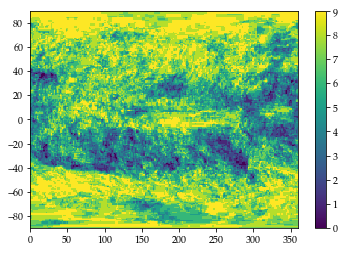

In [24]:
''' Add values of all arrays '''
sum_array_rcp45 = abs(np.sum(boolean_arrays_rcp45, axis = 2))
rs_lats_rcp45 = np.linspace(-90,90,180)
rs_lons_rcp45 = np.linspace(0, 360, 360)
plt.pcolormesh(rs_lons_rcp45, rs_lats_rcp45, sum_array_rcp45)
plt.colorbar()
plt.show()

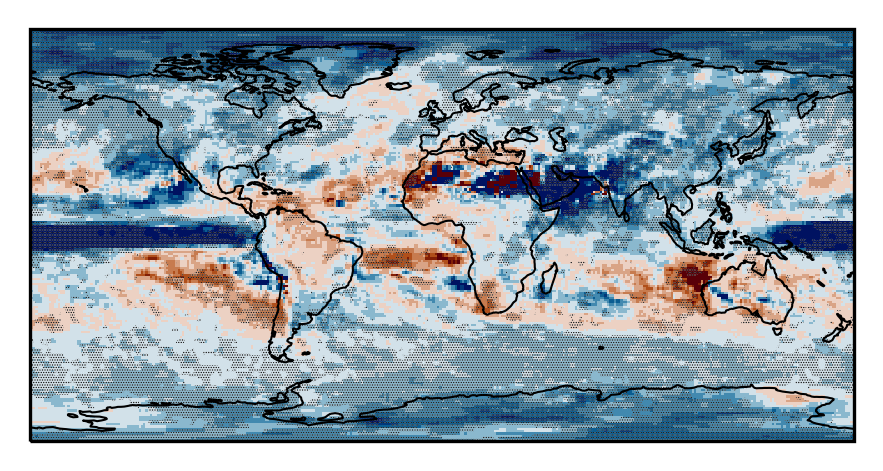

CPU times: user 52 s, sys: 365 ms, total: 52.4 s
Wall time: 52 s


In [31]:
%%time
resized_arrays_rcp45 = np.empty(shape=(180,360,len(fmr_arrays_rcp45)))

for ix, model in enumerate(fmr_arrays_rcp45):
    a = np.load(model)
    resized_arrays_rcp45[:,:,ix] = (skimage.transform.resize(a, (180,360), order = 0)).astype(int)
model_mean_rcp45 = np.mean(resized_arrays_rcp45, axis = 2)

''' Grid  cells where 7 or more models agree '''
matched_array_rcp45 = np.where(abs(sum_array_rcp45-4.5)>2, 1,0)

fig = plt.figure(1, figsize=(mm2inch(90,90)), frameon=True, dpi=300)
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(resolution='110m', color='k', linewidth=0.5, zorder = 9)

plt.pcolormesh(
    rs_lons_rcp45, rs_lats_rcp45, model_mean_rcp45,
    cmap = seg_cmap, norm=norm,
               transform = ccrs.PlateCarree(),vmin = -18, vmax=18)

plt.rcParams['hatch.color'] ="w"
plt.rcParams['hatch.linewidth'] = 0.5
C_rcp45 = ma.masked_where(matched_array_rcp45 == 0, matched_array_rcp45)
plt.contourf(rs_lons_rcp45, rs_lats_rcp45, C_rcp45,
             hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree())
plt.rcParams['hatch.color'] ="k"
plt.rcParams['hatch.linewidth'] = 0.2
plt.contourf(rs_lons_rcp45, rs_lats_rcp45, C_rcp45,
             hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree())
plt.show()


In [32]:
''' lat/lon points where models agree '''
stipple_points_rcp45 = []
for i, lat in enumerate(rs_lats_rcp45):
    for j, lon in enumerate(rs_lons_rcp45[:-1]):
        if matched_array_rcp45[i,j] == 1:
            stipple_points_rcp45.append(tuple([lon, lat]))

In [33]:
''' colours for matching points '''
stipple_colors_rcp45 = []
for i, lat in enumerate(rs_lats_rcp45):
    for j, lon in enumerate(rs_lons_rcp45[:-1]):
        if matched_array_rcp45[i,j] == 1:
            if model_mean_rcp45[i,j] >= 0:
                stipple_colors_rcp45.append(vik_map_r(255))
            else:
                stipple_colors_rcp45.append(vik_map_r(0))

In [34]:
''' Print percentage agreement beween models '''
size = 1
for dim in np.shape(matched_array_rcp45): size *= dim
print("Global FMR sign agreement (7/9 models): {:.2f} %".format(len(stipple_points_rcp45)/size*100))

Global FMR sign agreement (7/9 models): 60.46 %


In [38]:
''' Create list of longitudes offset by 180 degrees '''
lons_360 = []
for lon in locations.lons:
    if lon <0:
        lons_360.append(360+lon)
    else:
        lons_360.append(lon)

In [39]:
''' relocate volcanoes acccording to offset '''
relocated = []
i_reloc =[]
j_reloc =[]

for i, lat in enumerate(locations.lats):
    i_reloc.append(min(rs_lats_rcp45, key=lambda x:abs(x-lat)))  
for j, lon in enumerate(lons_360):
    j_reloc.append(min(rs_lons_rcp45, key=lambda x:abs(x-lon)))
relocated = list(zip(j_reloc, i_reloc))
assert len(locations) == len(relocated)

### Determine how many volcanoes rainfall will increase, decrease, or if there is insufficient model agreement

In [40]:
volcano_colors_rcp45 = []
volc_wetter = 0
volc_drier = 0
volc_ambig = 0
fmr_val_rcp45 = []
fmr_rcp45 = []
for tup in relocated:
    i = list(rs_lats_rcp45).index(tup[1])
    j = list(rs_lons_rcp45).index(tup[0])
    fmr_val_rcp45.append(model_mean_rcp45[i,j])
    if matched_array_rcp45[i,j] == 1:
        if model_mean_rcp45[i,j] >= 0:
            volcano_colors_rcp45.append(vik_map_r(255))
            volc_wetter+=1
            fmr_rcp45.append('pos')
        else:
            volcano_colors_rcp45.append(vik_map_r(0))
            volc_drier+=1
            fmr_rcp45.append('neg')
    else:
        volcano_colors_rcp45.append("grey")
        volc_ambig+=1
        fmr_rcp45.append('amb')
# print(len(volcano_colors))
print("wetter: {} ({:.0f} %); drier: {} ({:.0f} %); ambiguous {} ({:.0f} %)".format(volc_wetter, 
                                                                                    (volc_wetter/len(volcano_colors_rcp45))*100,
                                                                                    volc_drier,
                                                                                    (volc_drier/len(volcano_colors_rcp45))*100,
                                                                                    volc_ambig,
                                                                                   (volc_ambig/len(volcano_colors_rcp45))*100,))
print("{} volcanoes".format(sum([volc_wetter, volc_drier, volc_ambig])))

wetter: 507 (42 %); drier: 80 (7 %); ambiguous 630 (52 %)
1217 volcanoes


In [41]:
'''Update locations dataframe'''
locations_rcp45 = locations.copy()
locations_rcp45["relocated"] = relocated
locations_rcp45["FMR"] = fmr_rcp45
locations_rcp45["FMR_val"] = fmr_val_rcp45
locations_rcp45.head()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

lats   lons                       name  number  \
0  50.170   6.85  West Eifel Volcanic Field  210010   
1  45.775   2.97            Chaine des Puys  210020   
2  42.170   2.53        Olot Volcanic Field  210030   
3  38.870  -4.02   Calatrava Volcanic Field  210040   
4  42.600  11.93                    Vulsini  211003   

                                  relocated  FMR   FMR_val  
0  (7.0194986072423395, 49.776536312849174)  amb  2.000000  
1   (3.0083565459610027, 45.75418994413408)  pos  2.222222  
2   (3.0083565459610027, 41.73184357541899)  amb -0.666667  
3   (355.98885793871864, 38.71508379888269)  amb  0.777778  
4    (12.03342618384401, 42.73743016759778)  pos  3.333333

In [42]:
'''
Top n volcanoes sorted by FMR value (values above 0 only)
'''
n = 5
locations_rcp45[locations_rcp45.FMR=="pos"].nlargest(n, "FMR_val")

lats     lons                   name  number  \
159  25.170   37.750       Lunayyir, Harrat  231040   
156  18.330   32.750  Bayuda Volcanic Field  225060   
163  18.370   41.630        Birk, Harrat al  231072   
291  -3.125  152.642                  Lihir  254010   
176  28.070   60.000                 Bazman  232030   

                                    relocated  FMR       FMR_val  
159     (38.1058495821727, 25.64245810055867)  pos  47361.444444  
156    (33.09192200557103, 18.60335195530726)  pos  42244.111111  
163   (42.116991643454035, 18.60335195530726)  pos    440.888889  
291  (152.4233983286908, -3.5195530726256976)  pos    133.111111  
176     (60.16713091922006, 27.6536312849162)  pos     36.666667

In [43]:
'''
Separate volcanoes according to their forced model response
'''
fmr_pos_rcp45 = locations_rcp45[locations_rcp45["FMR"] == "pos"].name.reset_index()
fmr_neg_rcp45 = locations_rcp45[locations_rcp45["FMR"] == "neg"].name.reset_index()
fmr_amb_rcp45 = locations_rcp45[locations_rcp45["FMR"] == "amb"].name.reset_index()
fmr_pos_rcp45.head()

index             name
0      1  Chaine des Puys
1      4          Vulsini
2     32           Elbrus
3     33           Kazbek
4     40   Tair, Jebel at

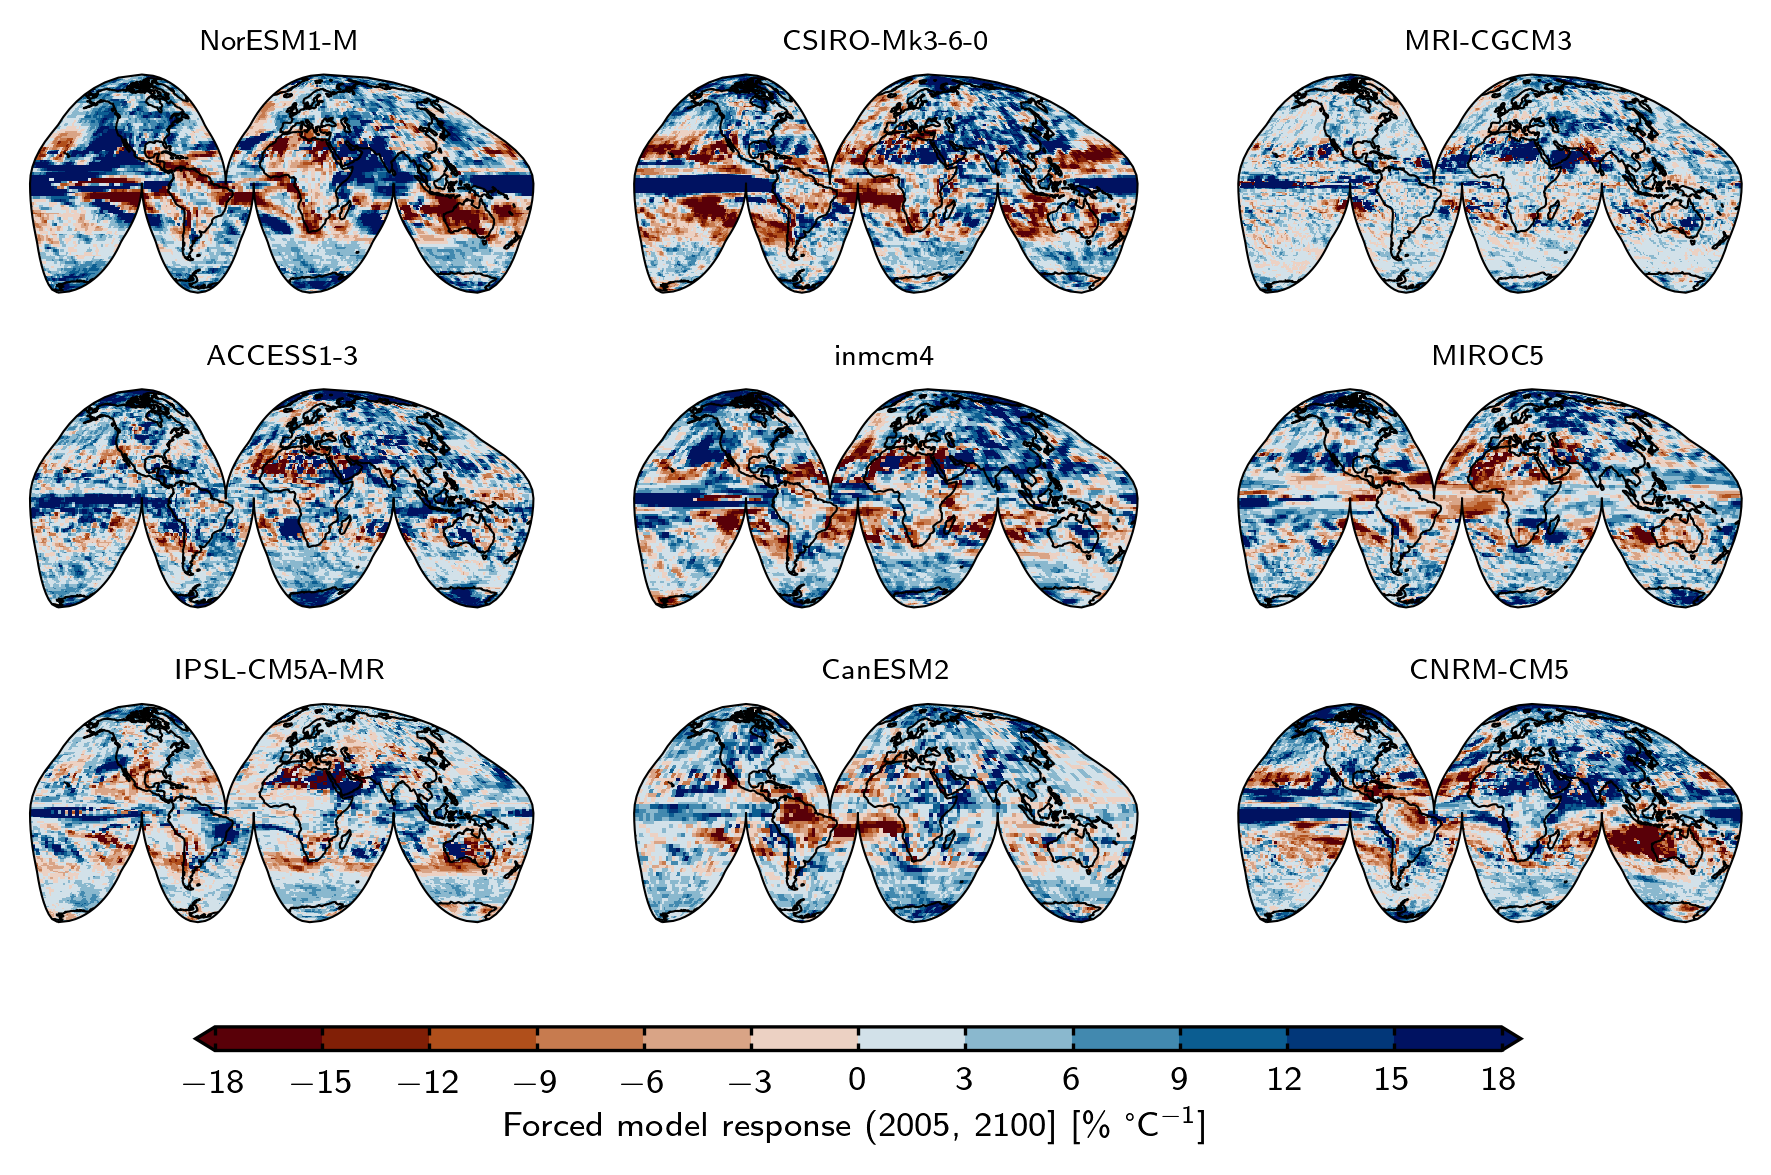

In [44]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(187,100)), frameon=True, dpi=300)
gs = plt.GridSpec(3, 3, figure=fig, wspace=0, hspace=0
                 )

axs = [fig.add_subplot((gs[0,0])),
       fig.add_subplot((gs[0,1])),
       fig.add_subplot((gs[0,2])),
       fig.add_subplot((gs[1,0])),
       fig.add_subplot((gs[1,1])),
       fig.add_subplot((gs[1,2])),
       fig.add_subplot((gs[2,0])),
       fig.add_subplot((gs[2,1])),
       fig.add_subplot((gs[2,2])),
      ]
for n in range(9):
    axs[n] = plt.subplot(3, 3, n+1,
                         projection=ccrs.InterruptedGoodeHomolosine(central_longitude=0))
    

for n in range(9):
    im = axs[n].pcolormesh(rs_lons_rcp45, rs_lats_rcp45,
                           resized_arrays_rcp45[:,:,n],
#                            resized_arrays[:,:,n],
                     cmap = seg_cmap, norm=norm,
               transform = ccrs.PlateCarree(),vmin = -18, vmax=18)
    axs[n].coastlines(resolution='110m', color='k', linewidth=0.5, zorder = 11)
    axs[n].outline_patch.set_linewidth(0.5)
    axs[n].outline_patch.set_zorder(50)
    axs[n].set_title(fileNameCodes[0][n], fontsize = "x-small")
#     axs[n].add_feature(cfeature.OCEAN, zorder = 10, color = 'w')
cax = plt.axes([0.2, 0.035, 0.6, 0.02])
cbar = plt.colorbar(im,cax=cax,orientation='horizontal',
                       extend = "both",extendfrac = .015, shrink = 1,pad = .5,
                    ticks = np.arange(-18,19,3))

cbar.ax.set_ylabel(r"Forced model response (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", rotation=0, fontsize = "small")
cbar.ax.yaxis.set_label_coords(0.5,-4)#1.5)
cbar.ax.tick_params(labelsize="small", direction = "in", length = 2)
cbar.ax.xaxis.set_ticks_position('both')
plt.show()


#### Figure 1 | Forced model response for all compared models.
GCM codes (as listed in Table 1, Methods) are shown above the corresponding map. Forced model response (FMR) as  _RX_ versus 〈_T_〉 over the timeframe from 2005 or 2006 to 2100, normalised to 2006, for RCP 4.5. Blue tones represent an increase in extreme rainfall with increased global warming, red tones represent a decrease.

In [45]:
'''Create dictionary of descriptive stats for different volcano sets (RCP45)'''
pos_fmr_vals_rcp45 = [x for x in locations_rcp45[locations_rcp45["FMR"] == "pos"].FMR_val.values]
log_vals_rcp45 = [np.log10(x) for x in pos_fmr_vals_rcp45] # 'pos' data is lognormal
log_vals_rcp45 = [x for x in log_vals_rcp45 if not math.isinf(x)]
dist_dict_rcp45 = {}
dist_dict_rcp45["pos"] = (10**np.nanmean(log_vals_rcp45),\
10**(np.nanmean(log_vals_rcp45)+(2*np.nanstd(log_vals_rcp45))),\
10**(np.nanmean(log_vals_rcp45)-(2*np.nanstd(log_vals_rcp45)))
)
for v in ["amb", "neg"]:
    vals_rcp45 = [x for x in locations_rcp45[locations_rcp45["FMR"] == v].FMR_val.values if x>-1000] #ignore spuriously low values
    mean_rcp45 = np.nanmean(vals_rcp45)
    std1_rcp45 = mean_rcp45+(2*np.nanstd(vals_rcp45))
    std2_rcp45 = mean_rcp45-(2*np.nanstd(vals_rcp45))
    dist_dict_rcp45[v] = (mean_rcp45, std2_rcp45, std1_rcp45)


In [46]:
def plot_FMR_distributions_rcp45(axis):
    bins_list = np.linspace(-10,42,50)
    y_val = [200,210,210]
    ax = axis
    for i,f in enumerate(sorted(set(locations_rcp45["FMR"]))):
        subset_rcp45 = locations_rcp45[locations_rcp45["FMR"] == f]
        ax.hist(subset_rcp45.FMR_val, bins = bins_list, density = False, histtype = "stepfilled",
                 ec = ["k", "firebrick","midnightblue"][i],
                 fc = ["k", "firebrick","midnightblue"][i],alpha = 0.65, lw =.5,
               label = r"{}{}".format(f, ["iguous", "ative", "itive"][i]))# zorder = 4-i)

        ax.hlines(y=y_val[i], xmin=dist_dict_rcp45[f][1], xmax=dist_dict_rcp45[f][2],
              color = ["k", "firebrick","midnightblue"][i], lw =.5)
        ax.vlines(x=dist_dict_rcp45[f][0], ymin=y_val[i]-8, ymax=y_val[i]+8,

              color = ["k", "firebrick","midnightblue"][i], lw =.5)
    for spine in ["top", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(-10,40)
    ax.set_xticks([-10,0,10,20,30,40])
    ax.set_ylim(0,220)
    ax.yaxis.tick_right()

    ax.spines["right"].set_position(("data", 30))
    ax.set_yticks([100,200])
    ax.legend(fancybox = False, frameon = False,
               markerscale= 1,fontsize = "x-small", 
              bbox_to_anchor=(.45, .8), loc=2,
              handletextpad=.3,
              ncol = 1)
    ax.set_xlabel(r"Mean FMR (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", fontsize = "small")



In [47]:
def plot_FMR_globe_rcp45(axis):

    ax1 = axis
    ax1.coastlines(resolution='50m', color='w', linewidth=1, zorder = 9)
    ax1.coastlines(resolution='50m', color='k', linewidth=0.5, zorder = 9)
    im =ax1.pcolormesh(
        rs_lons_rcp45, rs_lats_rcp45, model_mean_rcp45,
        cmap=vik_map_r,
                   transform = ccrs.PlateCarree(),vmin = -21, vmax=21)

    
    blank_rcp45 = ma.masked_where(matched_array_rcp45 == 1, matched_array_rcp45)
    ax1.contourf(rs_lons_rcp45, rs_lats_rcp45, blank_rcp45,
                 hatches =[15*'.',None], alpha=0.,transform = ccrs.PlateCarree()) #20*'.'

    plot_world_outlines_(C_rcp45.T,offs=(0,90.5),ax = axis,lw=.25, color='k',transform = ccrs.PlateCarree())
    ax1.outline_patch.set_linewidth(0.5)
    return im

# plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


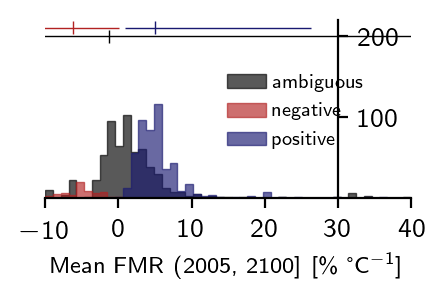

In [48]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(60,30)), frameon=True, dpi=200)
ax = fig.add_subplot(111)
plot_FMR_distributions_rcp45(axis=ax)

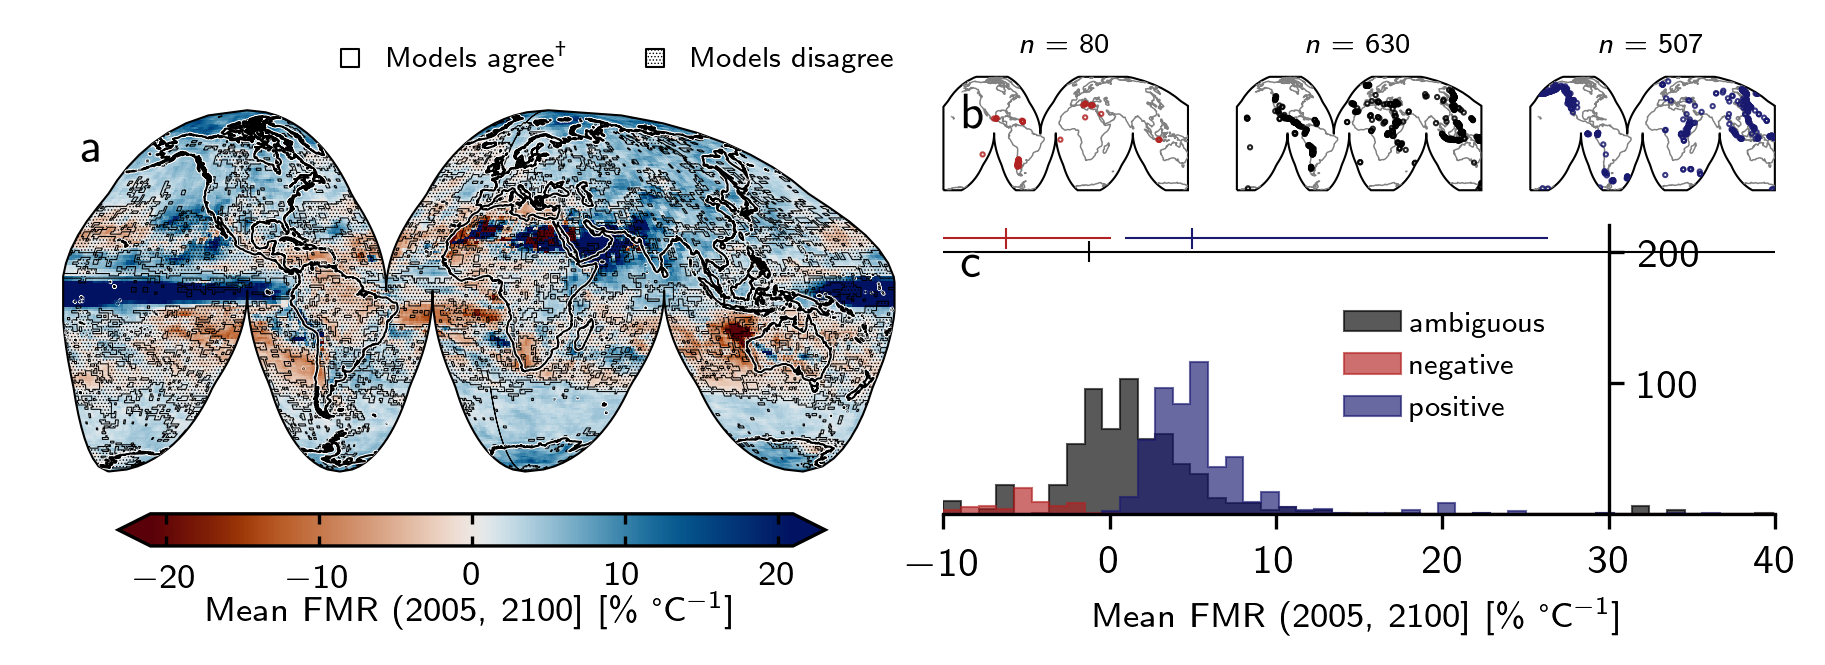

In [55]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(187,50)), frameon=True, dpi=300)
IGH = ccrs.InterruptedGoodeHomolosine(central_longitude=0)
axs = [plt.subplot2grid((3,6), (0,3), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,4), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,5), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (1,3), rowspan=2, colspan=3, fig=fig)]
plot_FMR_distributions_rcp45(axis=axs[-1])

for ix, lst in enumerate([fmr_neg_rcp45.name, fmr_amb_rcp45.name, fmr_pos_rcp45.name]):
    vset_rcp45 = list(lst)
    set_lons_rcp45 = locations_rcp45[locations_rcp45.name.isin(vset_rcp45)].lons.values
    set_lats_rcp45 = locations_rcp45[locations_rcp45.name.isin(vset_rcp45)].lats.values
    axis = axs[ix]
    axis.coastlines(resolution='110m', color='grey', linewidth=0.35, zorder = 9)
    axis.outline_patch.set_linewidth(0.5)
    axis.outline_patch.set_edgecolor("k")
    axis.scatter(set_lons_rcp45,set_lats_rcp45, marker = "o",
                 color = 'None', ec =['firebrick','k','midnightblue'][ix],
                    s = 1, transform = ccrs.PlateCarree(), lw = .5, zorder = 20, alpha = .85)
    axis.set_extent([-180,180,-80,80], ccrs.PlateCarree())
    axis.set_title(r"$n$ = {}".format(len(vset_rcp45)),fontsize = "x-small")
im = plot_FMR_globe_rcp45(axis=axs[3])
cax = fig.add_axes([0.11, 0.05, 0.4, 0.5])
cax.axis('off')
cbar = fig.colorbar(im,ax=cax,orientation='horizontal', extend = "both",
                    shrink = 0.8, ticks = [-20, -10, 0, 10, 20], )#pad = .1)
# cbar.ax.set_ylabel(r"Mean FMR (2005, 2100] [\% K$^{-1}$]", rotation=0, fontsize = "small")
cbar.ax.set_ylabel(r"Mean FMR (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", rotation=0, fontsize = "small")

cbar.ax.yaxis.set_label_coords(0.5,-2.6)
cbar.ax.tick_params(labelsize="small", direction = "in", length = 2.5)
cbar.ax.xaxis.set_ticks_position('both')
axs[1].tick_params(labelsize="small")
for ix, axis in enumerate([-2,0,-1]):
    axs[axis].annotate(STRING.ascii_lowercase[ix],**labelArgs, **labelKwargs)

plt.scatter([],[],marker = "s",s=300,lw=.5,ec = "k", color= "none", label = r"Models agree$^{{\dagger}}$")
plt.scatter([],[],marker = "s",hatch =15*'.',
            s=300,lw=.5,ec = "k", color= "none", label = "Models disagree")
plt.legend(fancybox = False, frameon = False,
               markerscale= .25,fontsize = "x-small", 
#               bbox_to_anchor=(1.7, 1), loc=6,
           bbox_to_anchor=(.3, 2), loc=6,
              handletextpad=.3,
              ncol = 2)
    
plt.savefig("climate_figures/figs4.png", bbox_inches="tight")
plt.savefig("climate_figures/figs4.pdf", bbox_inches="tight")
plt.show()


### Process data for RCP 2.6

In [56]:
def list_of_models_rcp26(parameter = "pr", modelName =""):
    import glob as glob
    models = [mod for mod in glob.glob("climate_mods/rcp26/{}*".format(parameter))]
    modelList = []
    for modelString in models:
        if modelName in modelString:
            modelList.append(modelString)
    return sorted(modelList)

In [57]:
def global_mean_temp_rcp26(modelName, method = "max", verbose = False):
    ''' "how" can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models_rcp26(parameter="ta", modelName=modelName))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        model_gmT = []
        for x in range(modelFile.variables["ta"].shape[0]):
            model_gmT.append(np.nanmean(modelFile.variables["ta"][x][0]))
        gmT_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'temp': model_gmT
    })
        gmT_df=gmT_df.set_index('ix')
        gmT_df.index = pd.to_datetime(gmT_df.index)
        gmT = gmT_df.resample("Y").agg(method)#, how=method)


        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return gmT, gmT_df
    except:
        funcName = sys._getframe().f_code.co_name
        print("Error reading {} ({})".format(modelName, funcName))

In [58]:
def process_FMR_rcp26(modelName="", resampled_gmT="", method = "max", verbose = False):
    ''' "how" method deprecated, use .agg(). Can be either "max" or "mean" '''
    try:
        modelFile = netCDF4.MFDataset(list_of_models_rcp26(parameter="pr", modelName=modelName))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        rx1 = []
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]

        count = len(lat_vals)
        bar_size=40
        for j, lat in enumerate(lat_vals):
            for k, lon in enumerate(lon_vals):
                prcp = list(modelFile["pr"][:,j,k])
                temp_df = pd.DataFrame(
            {'ix':time,'date':time, ##
             'rainfall': prcp
            })
                temp_df=temp_df.set_index('ix')
                temp_df.index = pd.to_datetime(temp_df.index)
                RX1 = temp_df.resample("Y").agg(method)

                gmT = resampled_gmT #temp_df.resample("Y").agg("mean")
                timeframe = [int(x) for x in np.linspace(RX1.index[0].year, RX1.index[-1].year,len(RX1.rainfall))]
                RX1val = [x for x in RX1.rainfall.values]
                gmTval = [x for x in gmT.temp.values]
                gmTval_n = [x - gmTval[1] for x in gmTval[1::]]
                RX1val_n = [(x-RX1val[1])/RX1val[1]*100 for x in RX1val[1::]]

                mask = ~np.isnan(gmTval_n) & ~np.isnan(RX1val_n)
                m, c, r, p, s = linregress(
                    np.array(gmTval_n)[mask],
                    np.array(RX1val_n)[mask])
                rx1.append(m)
            bar_frac = int(bar_size*(j+1)/count)
            print("{} {} rainfall: |{}{}| {}/{}".format("Processing",modelName,
                                               u"█"*bar_frac, u"\u22c5"*(bar_size-bar_frac),
                                               j+1, count), 
            end='\r', file=sys.stdout, flush=True)
        modelFile.close()
        rx1_rs=np.reshape(rx1, (len(lat_vals),len(lon_vals)))
        print("\n{} data reshaped  ".format(modelName))
        return rx1, rx1_rs
   
    except:
#         print("Error reading {}".format(modelName))
        funcName = sys._getframe().f_code.co_name
        print("Error reading {} ({})".format(modelName, funcName))

### The following cells allow the creation of numpy arrays from the original NetCDF model files.  
#### The user can skip to the cell `ls data/rcp26/*fmr.npy` to use pre-processed data


In [176]:

for mod in [0,1,2,5,6,7,8]:
    
    modelName = fileNameCodes[0][mod]
    method = "max"
    rcp45 = True
    if not list_of_models_rcp26(parameter = "pr", modelName =modelName) == []:
        global_mean_T, global_mean_T_df = global_mean_temp_rcp26(
            modelName=modelName,
            method = method, verbose = False)
        heavy_rain, heavy_rain_reshaped = process_FMR_rcp26(
            modelName=modelName,
            resampled_gmT=global_mean_T,
            method = method, verbose = False)

        modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName, rcp45=rcp45))
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]
        modelFile.close()
        rcp = "rcp26"
        np.save("data/rcp26/{}_{}_fmr".format(modelName,rcp), heavy_rain_reshaped, allow_pickle=True, fix_imports=True)
    #     np.save("data/{}_{}_fmr".format(modelName,rcp), heavy_rain_reshaped, allow_pickle=True, fix_imports=True)
        latitudes = [x for x in lat_vals]
        longitudes = [x for x in lon_vals]
        np.save("data/rcp26/{}_{}_lats".format(modelName,rcp), latitudes, allow_pickle=True, fix_imports=True)
        np.save("data/rcp26/{}_{}_lons".format(modelName,rcp), longitudes, allow_pickle=True, fix_imports=True)

        print("\n\u2713 {} processed and saved.\n".format(modelName))
#     print(modelName)

Processing NorESM1-M rainfall: |████████████████████████████████████████| 96/96
NorESM1-M data reshaped  

✓ NorESM1-M processed and saved.

Processing CSIRO-Mk3-6-0 rainfall: |████████████████████████████████████████| 96/96
CSIRO-Mk3-6-0 data reshaped  

✓ CSIRO-Mk3-6-0 processed and saved.

Processing MRI-CGCM3 rainfall: |████████████████████████████████████████| 160/160
MRI-CGCM3 data reshaped  

✓ MRI-CGCM3 processed and saved.

Processing MIROC5 rainfall: |████████████████████████████████████████| 128/128
MIROC5 data reshaped  

✓ MIROC5 processed and saved.

Processing IPSL-CM5A-MR rainfall: |████████████████████████████████████████| 143/143
IPSL-CM5A-MR data reshaped  

✓ IPSL-CM5A-MR processed and saved.

Error reading CanESM2 (process_FMR_rcp26)


TypeError: 'NoneType' object is not iterable

### Forced model response has been calculated for each model and is accessible as numpy arrays: RCP 2.6

In [61]:
ls data/rcp26/*fmr.npy

data/rcp26/CNRM-CM5_rcp26_fmr.npy       data/rcp26/MIROC5_rcp26_fmr.npy
data/rcp26/CSIRO-Mk3-6-0_rcp26_fmr.npy  data/rcp26/MRI-CGCM3_rcp26_fmr.npy
data/rcp26/CanESM2_rcp26_fmr.npy        data/rcp26/NorESM1-M_rcp26_fmr.npy
data/rcp26/IPSL-CM5A-MR_rcp26_fmr.npy


In [62]:
'''
Import forced model response data for different GCMs (RCP26).
Binarize data in terms of whether there is a projected increase or decrease in heavy precipitation per degree warming.
Resize arrays onto a common grid (180 x 360). Performs quick sanity check at end.
'''
 
fmr_arrays_rcp26 = glob.glob("data/rcp26/*fmr.npy")

boolean_arrays_rcp26 = np.empty(shape=(180,360,len(fmr_arrays_rcp26)))

for ix, model in enumerate(fmr_arrays_rcp26):

    boolean_arrays_rcp26[:,:,ix] = (
        skimage.transform.resize(           # resize all arrays onto a common grid
        np.where(np.load(model)>0, 1,0.),   # binarize model data {0|1}
        (180,360),                          # size of new grid
        order = 0)                          # Nearest neighbour interpolation
        ).astype(int)                       # Convert dtype using astype
    
for x in range(len(fmr_arrays_rcp26)):
    print("Everything looks good here" if set(np.ravel(boolean_arrays_rcp26[:,:,x])) == {1.0, 0.0} else "Problem here") # Sanity check

Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here


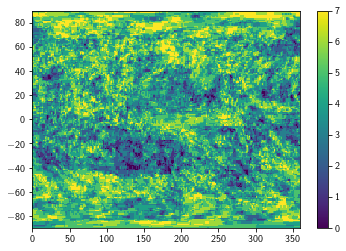

In [63]:
''' Add values of all arrays '''
sum_array_rcp26 = abs(np.sum(boolean_arrays_rcp26, axis = 2))
rs_lats_rcp26 = np.linspace(-90,90,180)
rs_lons_rcp26 = np.linspace(0, 360, 360)
plt.pcolormesh(rs_lons_rcp26, rs_lats_rcp26, sum_array_rcp26)
plt.colorbar()
plt.show()

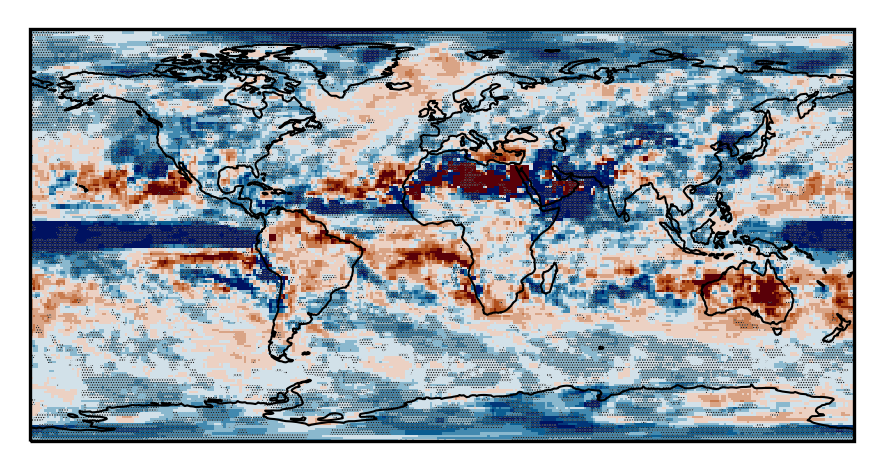

CPU times: user 1min 26s, sys: 4.77 s, total: 1min 31s
Wall time: 6min 31s


In [64]:
%%time
resized_arrays_rcp26 = np.empty(shape=(180,360,len(fmr_arrays_rcp26)))

for ix, model in enumerate(fmr_arrays_rcp26):
    a = np.load(model)
    resized_arrays_rcp26[:,:,ix] = (skimage.transform.resize(a, (180,360), order = 0)).astype(int)
model_mean_rcp26 = np.mean(resized_arrays_rcp26, axis = 2)

''' Grid  cells where 5(?) or more models agree '''
matched_array_rcp26 = np.where(abs(sum_array_rcp26-2.5)>2, 1,0) ## check this

fig = plt.figure(1, figsize=(mm2inch(90,90)), frameon=True, dpi=300)
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(resolution='110m', color='k', linewidth=0.5, zorder = 9)

plt.pcolormesh(
    rs_lons_rcp26, rs_lats_rcp26, model_mean_rcp26,
    cmap = seg_cmap, norm=norm,
               transform = ccrs.PlateCarree(),vmin = -18, vmax=18)

plt.rcParams['hatch.color'] ="w"
plt.rcParams['hatch.linewidth'] = 0.5
C_rcp26 = ma.masked_where(matched_array_rcp26 == 0, matched_array_rcp26)
plt.contourf(rs_lons_rcp26, rs_lats_rcp26, C_rcp26,
             hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree())
plt.rcParams['hatch.color'] ="k"
plt.rcParams['hatch.linewidth'] = 0.2
plt.contourf(rs_lons_rcp26, rs_lats_rcp26, C_rcp26,
             hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree())
plt.show()


In [65]:
''' lat/lon points where models agree '''
stipple_points_rcp26 = []
for i, lat in enumerate(rs_lats_rcp26):
    for j, lon in enumerate(rs_lons_rcp26[:-1]):
        if matched_array_rcp26[i,j] == 1:
            stipple_points_rcp26.append(tuple([lon, lat]))

In [66]:
''' colours for matching points '''
stipple_colors_rcp26 = []
for i, lat in enumerate(rs_lats_rcp26):
    for j, lon in enumerate(rs_lons_rcp26[:-1]):
        if matched_array_rcp26[i,j] == 1:
            if model_mean_rcp26[i,j] >= 0:
                stipple_colors_rcp26.append(vik_map_r(255))
            else:
                stipple_colors_rcp26.append(vik_map_r(0))

In [67]:
''' Print percentage agreement beween models '''
size = 1
for dim in np.shape(matched_array_rcp26): size *= dim
print("Global FMR sign agreement (5/7 models): {:.2f} %".format(len(stipple_points_rcp26)/size*100))

Global FMR sign agreement (5/7 models): 46.20 %


In [68]:
''' Create list of longitudes offset by 180 degrees '''
lons_360 = []
for lon in locations.lons:
    if lon <0:
        lons_360.append(360+lon)
    else:
        lons_360.append(lon)

In [69]:
''' relocate volcanoes acccording to offset '''
relocated = []
i_reloc =[]
j_reloc =[]

for i, lat in enumerate(locations.lats):
    i_reloc.append(min(rs_lats_rcp26, key=lambda x:abs(x-lat)))  
for j, lon in enumerate(lons_360):
    j_reloc.append(min(rs_lons_rcp26, key=lambda x:abs(x-lon)))
relocated = list(zip(j_reloc, i_reloc))
assert len(locations) == len(relocated)

### Determine how many volcanoes rainfall will increase, decrease, or if there is insufficient model agreement

In [70]:
volcano_colors_rcp26 = []
volc_wetter = 0
volc_drier = 0
volc_ambig = 0
fmr_val_rcp26 = []
fmr_rcp26 = []
for tup in relocated:
    i = list(rs_lats_rcp26).index(tup[1])
    j = list(rs_lons_rcp26).index(tup[0])
    fmr_val_rcp26.append(model_mean_rcp26[i,j])
    if matched_array_rcp26[i,j] == 1:
        if model_mean_rcp26[i,j] >= 0:
            volcano_colors_rcp26.append(vik_map_r(255))
            volc_wetter+=1
            fmr_rcp26.append('pos')
        else:
            volcano_colors_rcp26.append(vik_map_r(0))
            volc_drier+=1
            fmr_rcp26.append('neg')
    else:
        volcano_colors_rcp26.append("grey")
        volc_ambig+=1
        fmr_rcp26.append('amb')
# print(len(volcano_colors))
print("wetter: {} ({:.0f} %); drier: {} ({:.0f} %); ambiguous {} ({:.0f} %)".format(volc_wetter, 
                                                                                    (volc_wetter/len(volcano_colors_rcp26))*100,
                                                                                    volc_drier,
                                                                                    (volc_drier/len(volcano_colors_rcp26))*100,
                                                                                    volc_ambig,
                                                                                   (volc_ambig/len(volcano_colors_rcp26))*100,))
print("{} volcanoes".format(sum([volc_wetter, volc_drier, volc_ambig])))

wetter: 413 (34 %); drier: 21 (2 %); ambiguous 783 (64 %)
1217 volcanoes


In [71]:
'''Update locations dataframe'''
locations_rcp26 = locations.copy()
locations_rcp26["relocated"] = relocated
locations_rcp26["FMR"] = fmr_rcp26
locations_rcp26["FMR_val"] = fmr_val_rcp26
locations_rcp26.head()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

lats   lons                       name  number  \
0  50.170   6.85  West Eifel Volcanic Field  210010   
1  45.775   2.97            Chaine des Puys  210020   
2  42.170   2.53        Olot Volcanic Field  210030   
3  38.870  -4.02   Calatrava Volcanic Field  210040   
4  42.600  11.93                    Vulsini  211003   

                                  relocated  FMR   FMR_val  
0  (7.0194986072423395, 49.776536312849174)  pos  5.285714  
1   (3.0083565459610027, 45.75418994413408)  pos  4.142857  
2   (3.0083565459610027, 41.73184357541899)  amb  2.857143  
3   (355.98885793871864, 38.71508379888269)  pos  8.428571  
4    (12.03342618384401, 42.73743016759778)  amb -0.857143

In [72]:
'''
Top n volcanoes sorted by FMR value (values above 0 only)
'''
n = 5
locations_rcp26[locations_rcp26.FMR=="pos"].nlargest(n, "FMR_val")

lats    lons              name  number  \
159   25.17  37.750  Lunayyir, Harrat  231040   
1069  -0.02 -91.546           Ecuador  353011   
1070  -0.37 -91.550        Fernandina  353010   
1072  -0.18 -91.280            Darwin  353030   
1073  -0.43 -91.120            Alcedo  353040   

                                     relocated  FMR        FMR_val  
159      (38.1058495821727, 25.64245810055867)  pos  932036.714286  
1069  (268.7465181058496, -0.5027932960893793)  pos      49.571429  
1070  (268.7465181058496, -0.5027932960893793)  pos      49.571429  
1072  (268.7465181058496, -0.5027932960893793)  pos      49.571429  
1073  (268.7465181058496, -0.5027932960893793)  pos      49.571429

In [73]:
'''
Separate volcanoes according to their forced model response
'''
fmr_pos_rcp26 = locations_rcp26[locations_rcp26["FMR"] == "pos"].name.reset_index()
fmr_neg_rcp26 = locations_rcp26[locations_rcp26["FMR"] == "neg"].name.reset_index()
fmr_amb_rcp26 = locations_rcp26[locations_rcp26["FMR"] == "amb"].name.reset_index()
fmr_pos_rcp26.head()

index                       name
0      0  West Eifel Volcanic Field
1      1            Chaine des Puys
2      3   Calatrava Volcanic Field
3     14                       Etna
4     35                    Aragats

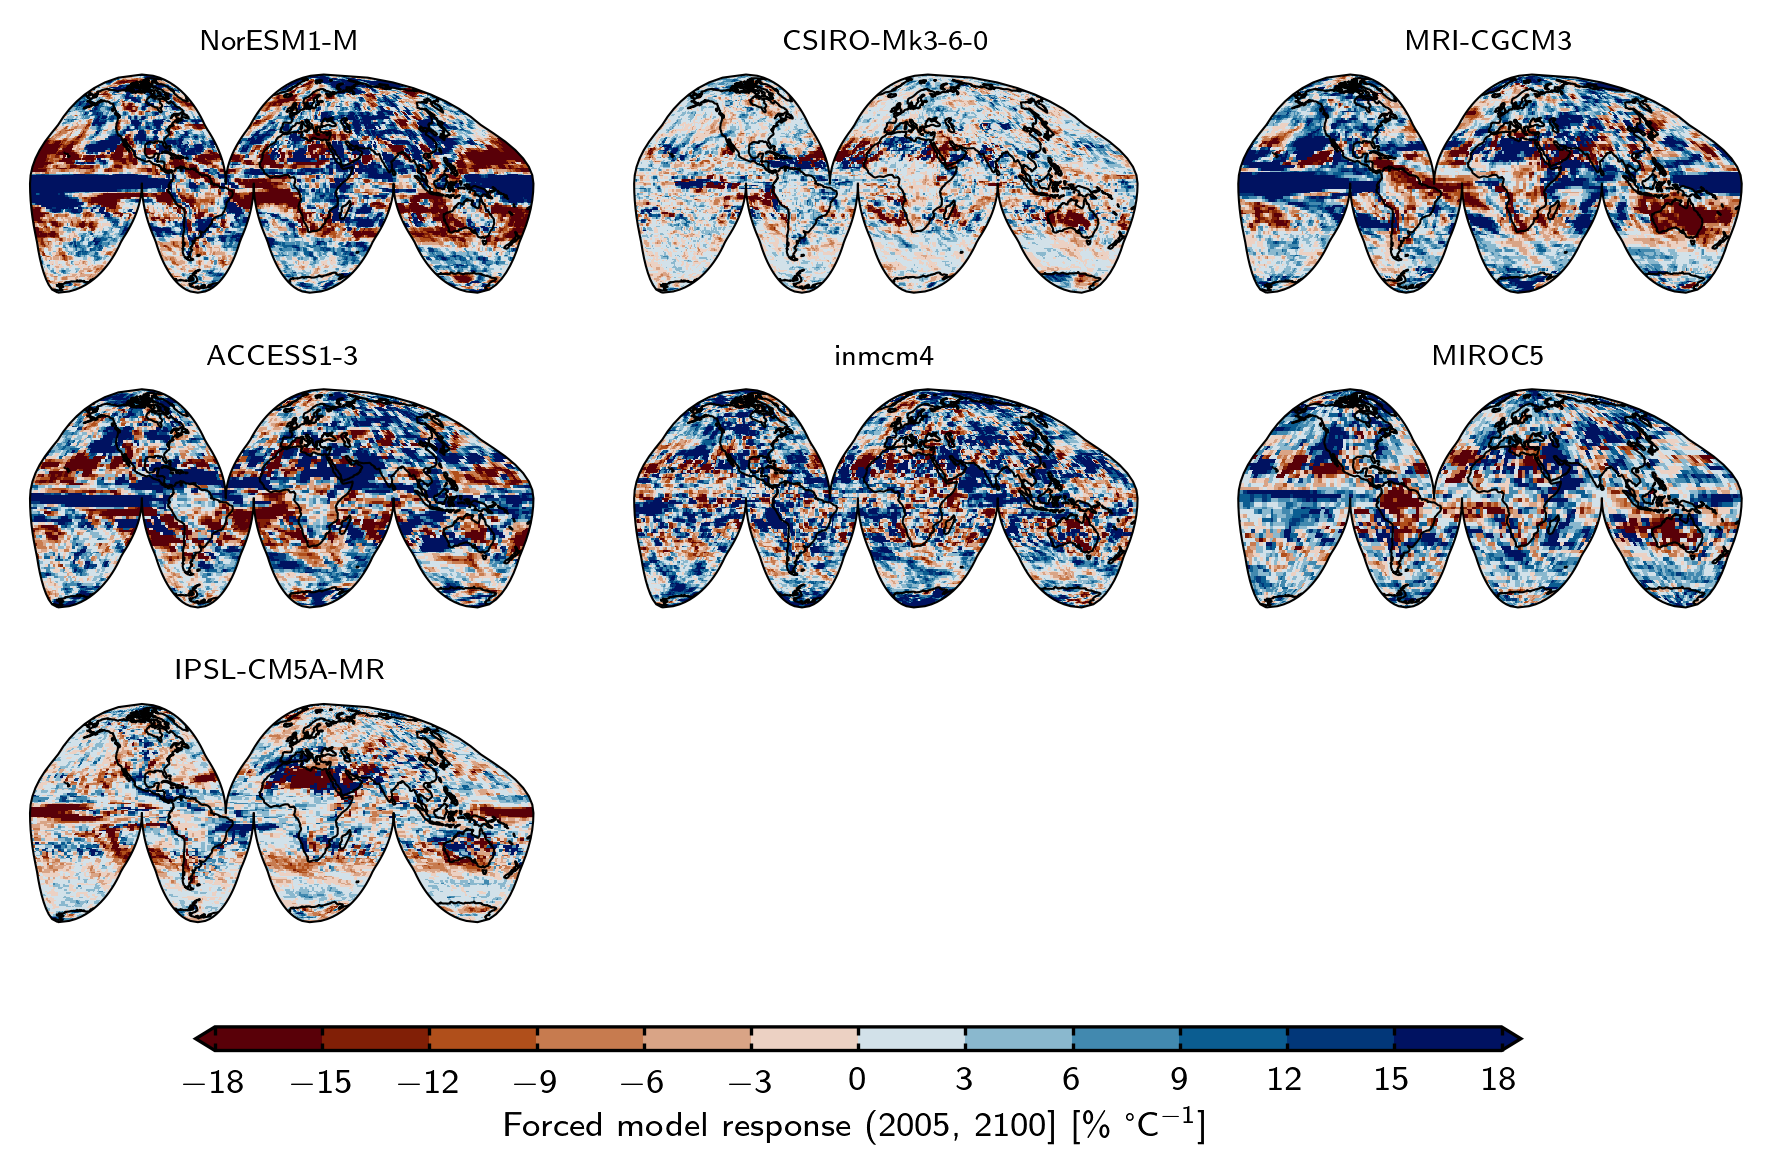

In [74]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(187,100)), frameon=True, dpi=300)
gs = plt.GridSpec(3, 3, figure=fig, wspace=0, hspace=0
                 )

axs = [fig.add_subplot((gs[0,0])),
       fig.add_subplot((gs[0,1])),
       fig.add_subplot((gs[0,2])),
       fig.add_subplot((gs[1,0])),
       fig.add_subplot((gs[1,1])),
       fig.add_subplot((gs[1,2])),
       fig.add_subplot((gs[2,0])),
#        fig.add_subplot((gs[2,1])),
#        fig.add_subplot((gs[2,2])),
      ]
for n in range(7):
    axs[n] = plt.subplot(3, 3, n+1,
                         projection=ccrs.InterruptedGoodeHomolosine(central_longitude=0))
    

for n in range(7):
    im = axs[n].pcolormesh(rs_lons_rcp26, rs_lats_rcp26,
                           resized_arrays_rcp26[:,:,n],
#                            resized_arrays[:,:,n],
                     cmap = seg_cmap, norm=norm,
               transform = ccrs.PlateCarree(),vmin = -18, vmax=18)
    axs[n].coastlines(resolution='110m', color='k', linewidth=0.5, zorder = 11)
    axs[n].outline_patch.set_linewidth(0.5)
    axs[n].outline_patch.set_zorder(50)
    axs[n].set_title(fileNameCodes[0][n], fontsize = "x-small")
#     axs[n].add_feature(cfeature.OCEAN, zorder = 10, color = 'w')
cax = plt.axes([0.2, 0.035, 0.6, 0.02])
cbar = plt.colorbar(im,cax=cax,orientation='horizontal',
                       extend = "both",extendfrac = .015, shrink = 1,pad = .5,
                    ticks = np.arange(-18,19,3))

cbar.ax.set_ylabel(r"Forced model response (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", rotation=0, fontsize = "small")
cbar.ax.yaxis.set_label_coords(0.5,-4)#1.5)
cbar.ax.tick_params(labelsize="small", direction = "in", length = 2)
cbar.ax.xaxis.set_ticks_position('both')

plt.show()


#### Figure 1 | Forced model response for all compared models.
GCM codes (as listed in Table 1, Methods) are shown above the corresponding map. Forced model response (FMR) as  _RX_ versus 〈_T_〉 over the timeframe from 2005 or 2006 to 2100, normalised to 2006, for RCP 2.6. Blue tones represent an increase in extreme rainfall with increased global warming, red tones represent a decrease.

In [75]:
'''Create dictionary of descriptive stats for different volcano sets'''
pos_fmr_vals_rcp26 = [x for x in locations_rcp26[locations_rcp26["FMR"] == "pos"].FMR_val.values]
log_vals_rcp26 = [np.log10(x) for x in pos_fmr_vals_rcp26] # 'pos' data is lognormal
log_vals_rcp26 = [x for x in log_vals_rcp26 if not math.isinf(x)]
dist_dict = {}
dist_dict["pos"] = (10**np.nanmean(log_vals_rcp26),\
10**(np.nanmean(log_vals_rcp26)+(2*np.nanstd(log_vals_rcp26))),\
10**(np.nanmean(log_vals_rcp26)-(2*np.nanstd(log_vals_rcp26)))
)
for v in ["amb", "neg"]:
    vals_rcp26 = [x for x in locations_rcp26[locations_rcp26["FMR"] == v].FMR_val.values if x>-1000] #ignore spuriously low values
    mean_rcp26 = np.nanmean(vals_rcp26)
    std1_rcp26 = mean_rcp26+(2*np.nanstd(vals_rcp26))
    std2_rcp26 = mean_rcp26-(2*np.nanstd(vals_rcp26))
    dist_dict[v] = (mean_rcp26, std2_rcp26, std1_rcp26)


In [76]:
'''Create dictionary of descriptive stats for different volcano sets (RCP26)'''
pos_fmr_vals_rcp26 = [x for x in locations_rcp26[locations_rcp26["FMR"] == "pos"].FMR_val.values]
log_vals_rcp26 = [np.log10(x) for x in pos_fmr_vals_rcp26] # 'pos' data is lognormal
log_vals_rcp26 = [x for x in log_vals_rcp26 if not math.isinf(x)]
dist_dict_rcp26 = {}
dist_dict_rcp26["pos"] = (10**np.nanmean(log_vals_rcp26),\
10**(np.nanmean(log_vals_rcp26)+(2*np.nanstd(log_vals_rcp26))),\
10**(np.nanmean(log_vals_rcp26)-(2*np.nanstd(log_vals_rcp26)))
)
for v in ["amb", "neg"]:
    vals_rcp26 = [x for x in locations_rcp26[locations_rcp26["FMR"] == v].FMR_val.values if x>-1000] #ignore spuriously low values
    mean_rcp26 = np.nanmean(vals_rcp26)
    std1_rcp26 = mean_rcp26+(2*np.nanstd(vals_rcp26))
    std2_rcp26 = mean_rcp26-(2*np.nanstd(vals_rcp26))
    dist_dict_rcp26[v] = (mean_rcp26, std2_rcp26, std1_rcp26)


In [77]:
def plot_FMR_distributions_rcp26(axis):
    bins_list = np.linspace(-10,42,50)
    y_val = [200,210,210]
    ax = axis
    for i,f in enumerate(sorted(set(locations_rcp26["FMR"]))):
        subset_rcp26 = locations_rcp26[locations_rcp26["FMR"] == f]
        ax.hist(subset_rcp26.FMR_val, bins = bins_list, density = False, histtype = "stepfilled",
                 ec = ["k", "firebrick","midnightblue"][i],
                 fc = ["k", "firebrick","midnightblue"][i],alpha = 0.65, lw =.5,
               label = r"{}{}".format(f, ["iguous", "ative", "itive"][i]))# zorder = 4-i)
    for spine in ["top", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(-10,40)
    ax.set_xticks([-10,0,10,20,30,40])
    ax.set_ylim(0,220)
    ax.yaxis.tick_right()

    ax.spines["right"].set_position(("data", 30))
    ax.set_yticks([100,200])
    ax.legend(fancybox = False, frameon = False,
               markerscale= 1,fontsize = "x-small", 
              bbox_to_anchor=(.45, .8), loc=2,
              handletextpad=.3,
              ncol = 1)
#     ax.set_xlabel(r"Mean FMR (2005, 2100] [\% K$^{-1}$]", fontsize = "small")
    ax.set_xlabel(r"Mean FMR (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", fontsize = "small")



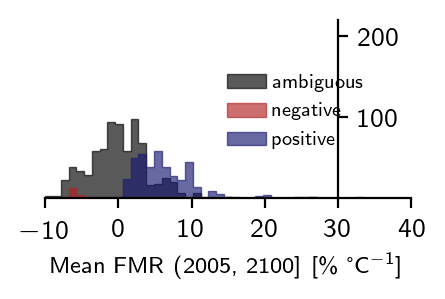

In [78]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(60,30)), frameon=True, dpi=200)
ax = fig.add_subplot(111)
plot_FMR_distributions_rcp26(axis=ax)

In [79]:
def plot_FMR_globe_rcp26(axis):

    ax1 = axis
    ax1.coastlines(resolution='50m', color='w', linewidth=1, zorder = 9)
    ax1.coastlines(resolution='50m', color='k', linewidth=0.5, zorder = 9)
    im =ax1.pcolormesh(
        rs_lons_rcp26, rs_lats_rcp26, model_mean_rcp26,
        cmap=vik_map_r,
                   transform = ccrs.PlateCarree(),vmin = -21, vmax=21)

    
    blank_rcp26 = ma.masked_where(matched_array_rcp26 == 1, matched_array_rcp26)
    ax1.contourf(rs_lons_rcp26, rs_lats_rcp26, blank_rcp26,
                 hatches =[15*'.',None], alpha=0.,transform = ccrs.PlateCarree()) #20*'.'

    plot_world_outlines_(C_rcp26.T,offs=(0,90.5),ax = axis,lw=.25, color='k',transform = ccrs.PlateCarree())
    ax1.outline_patch.set_linewidth(0.5)
    return im

# plt.show()

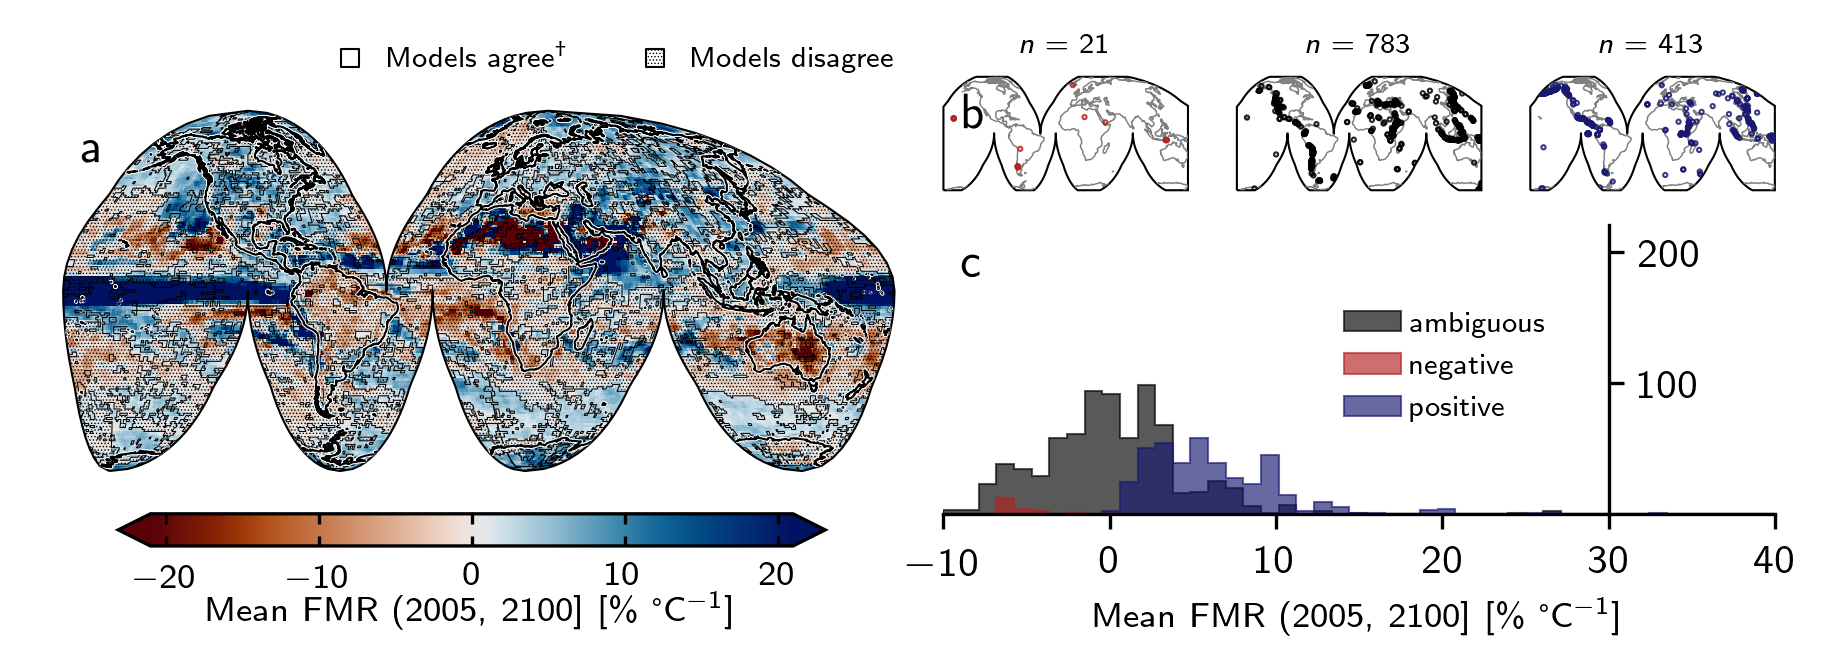

In [80]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(187,50)), frameon=True, dpi=300)
IGH = ccrs.InterruptedGoodeHomolosine(central_longitude=0)
axs = [plt.subplot2grid((3,6), (0,3), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,4), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,5), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (1,3), rowspan=2, colspan=3, fig=fig)]
plot_FMR_distributions_rcp26(axis=axs[-1])

for ix, lst in enumerate([fmr_neg_rcp26.name, fmr_amb_rcp26.name, fmr_pos_rcp26.name]):
    vset_rcp26 = list(lst)
    set_lons_rcp26 = locations_rcp26[locations_rcp26.name.isin(vset_rcp26)].lons.values
    set_lats_rcp26 = locations_rcp26[locations_rcp26.name.isin(vset_rcp26)].lats.values
    axis = axs[ix]
    axis.coastlines(resolution='110m', color='grey', linewidth=0.35, zorder = 9)
    axis.outline_patch.set_linewidth(0.5)
    axis.outline_patch.set_edgecolor("k")
    axis.scatter(set_lons_rcp26,set_lats_rcp26, marker = "o",
                 color = 'None', ec =['firebrick','k','midnightblue'][ix],
                    s = 1, transform = ccrs.PlateCarree(), lw = .5, zorder = 20, alpha = .85)
    axis.set_extent([-180,180,-80,80], ccrs.PlateCarree())
    axis.set_title(r"$n$ = {}".format(len(vset_rcp26)),fontsize = "x-small")
im = plot_FMR_globe_rcp26(axis=axs[3])
cax = fig.add_axes([0.11, 0.05, 0.4, 0.5])
cax.axis('off')
cbar = fig.colorbar(im,ax=cax,orientation='horizontal', extend = "both",
                    shrink = 0.8, ticks = [-20, -10, 0, 10, 20], )#pad = .1)
cbar.ax.set_ylabel(r"Mean FMR (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", rotation=0, fontsize = "small")

cbar.ax.yaxis.set_label_coords(0.5,-2.6)
cbar.ax.tick_params(labelsize="small", direction = "in", length = 2.5)
cbar.ax.xaxis.set_ticks_position('both')
axs[1].tick_params(labelsize="small")
for ix, axis in enumerate([-2,0,-1]):
    axs[axis].annotate(STRING.ascii_lowercase[ix],**labelArgs, **labelKwargs)

plt.scatter([],[],marker = "s",s=300,lw=.5,ec = "k", color= "none", label = r"Models agree$^{{\dagger}}$")
plt.scatter([],[],marker = "s",hatch =15*'.',
            s=300,lw=.5,ec = "k", color= "none", label = "Models disagree")
plt.legend(fancybox = False, frameon = False,
               markerscale= .25,fontsize = "x-small", 
#               bbox_to_anchor=(1.7, 1), loc=6,
           bbox_to_anchor=(.3, 2), loc=6,
              handletextpad=.3,
              ncol = 2)
    
plt.savefig("climate_figures/figs6.png", bbox_inches="tight")
plt.savefig("climate_figures/figs6.pdf", bbox_inches="tight")
plt.show()
